# Ridge

In [25]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get Data

In [26]:
from common.data import get_data
from common.paths import HEALTHY, ADHD_ONE

X, Y, demographics, population = get_data(wisc_level=5, label_path=HEALTHY)
ages = demographics['Age']

print(f'X: {X.shape} | Y: {len(Y.keys())} | Age: {ages.shape} | Population: {population}')

X: (106, 34716) | Y: 6 | Age: (106,) | Population: healthy


In [27]:
from common.scoring import unimetric_scorer, multimetric_scorer, N_PERM, SCORING, RKF_10_10
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_validate, permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

## Run for one target, one age bin

In [11]:
selected_target = "WISC_FSIQ"
y = Y[selected_target]

print(f'y: {y.shape}')

y: (106,)


In [29]:
from common.binning import bin_by_age

bins = bin_by_age(X, y, ages)
bin_1, bin_2, bin_3 = bins[0], bins[1], bins[2]
print(f'Bin 1: {bin_1[0].shape} | Bin 2: {bin_2[0].shape} | Bin 3: {bin_3[0].shape}')

Bin 1: (45, 34716) | Bin 2: (35, 34716) | Bin 3: (26, 34716)


### Set up the model pipeline, metrics, and cross-validation approach

In [18]:
%%time
# X_cv = bin_1[0]
# y_cv = bin_1[1]
X_cv = X
y_cv = y
age_group = 'all'

estimators = [StandardScaler(), RidgeCV(alphas=[a for a in range(5000, 75000, 5000)], 
                                        scoring=unimetric_scorer, cv=RKF_10_10)]
pipe = make_pipeline(*estimators)
pipe.fit(X_cv, y_cv)
ridge_cv = pipe['ridgecv']

print(f'Target: {selected_target} | Alpha: {ridge_cv.alpha_} | Score: {ridge_cv.best_score_:.2f}')

Target: WISC_FSIQ | Alpha: 1 | Score: 0.04
CPU times: user 165 ms, sys: 4.22 ms, total: 170 ms
Wall time: 86.4 ms


In [22]:
# alphas_ones = [10 ** e for e in range(-3, 4)]
# alphas_fives = [5 ** e for e in range(-3, 6)]
# alphas = alphas_ones + alphas_fives
# alphas = [a for a in range(1, 10000, 100)]
alphas = [a for a in range(1, 500, 1)]
scores = []

for a in alphas:
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=a))
    score = cross_validate(pipe, X, y, cv=RKF_10_10, scoring=unimetric_scorer, n_jobs=-1, 
                           return_estimator=False)
    scores.append(np.mean(score["test_score"]))
#     print(f'Alpha: {a}, Score: {scores[-1]}')
print('num scores:', len(scores))

num scores: 499


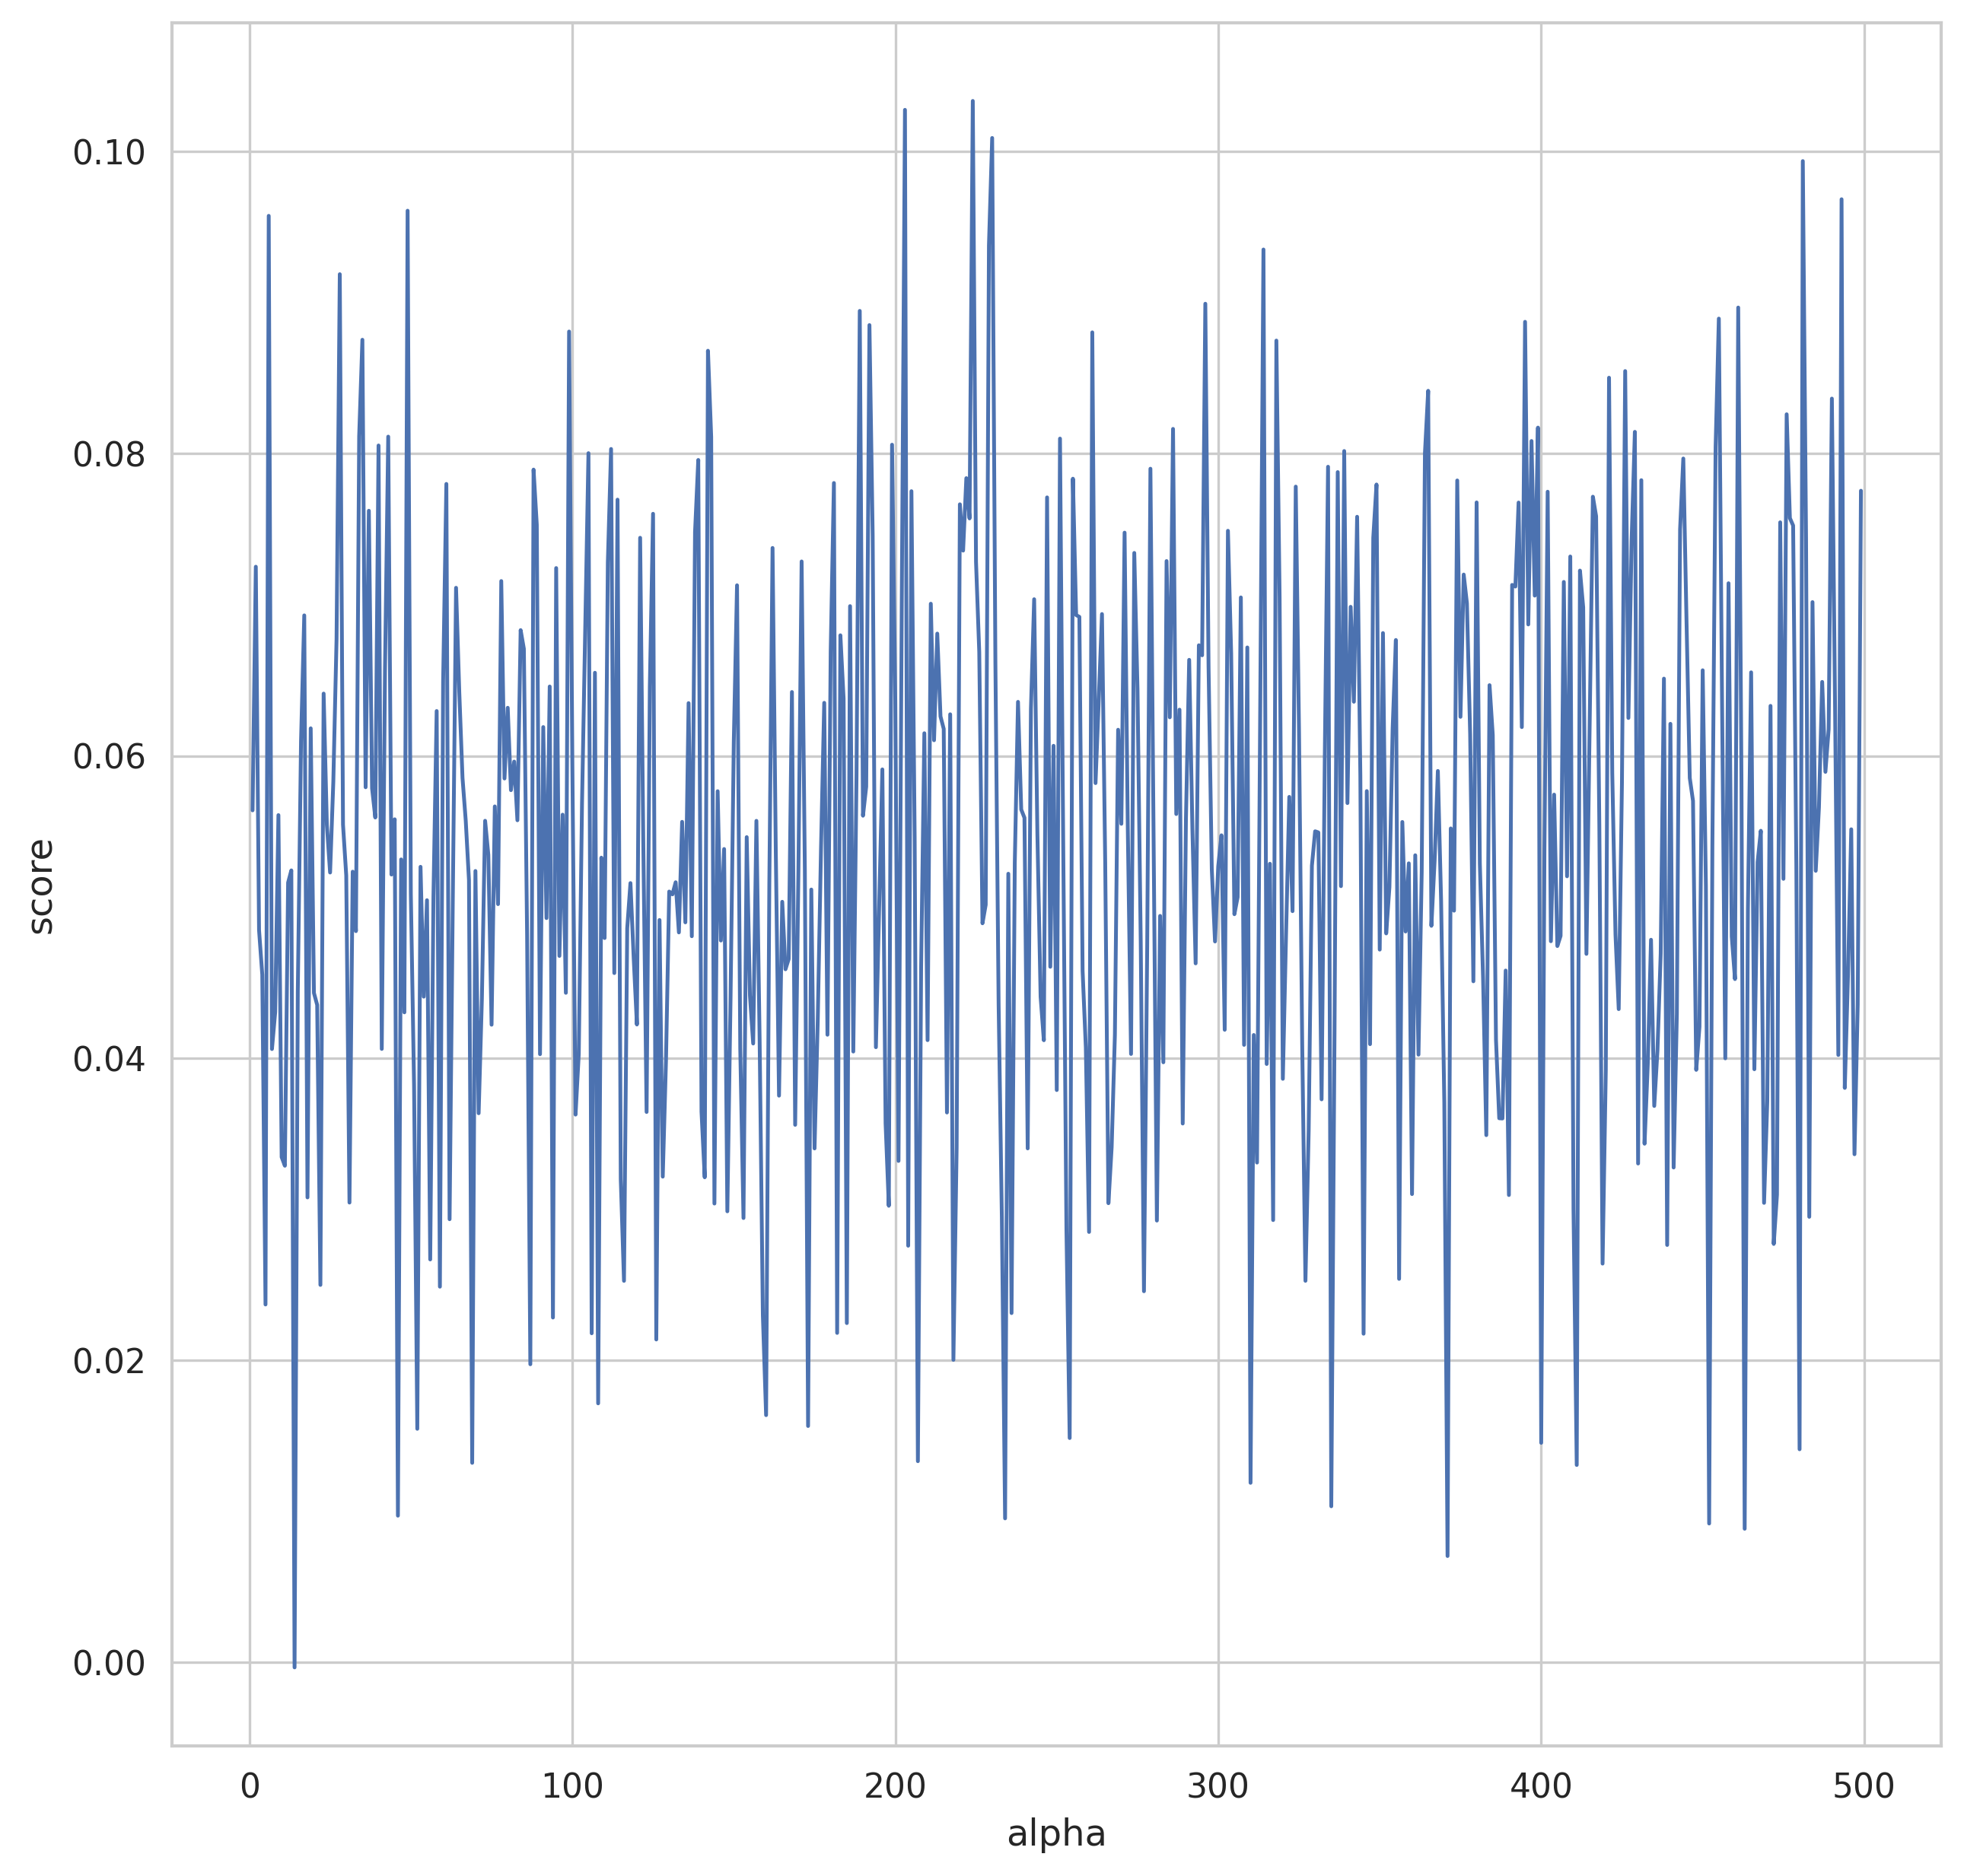

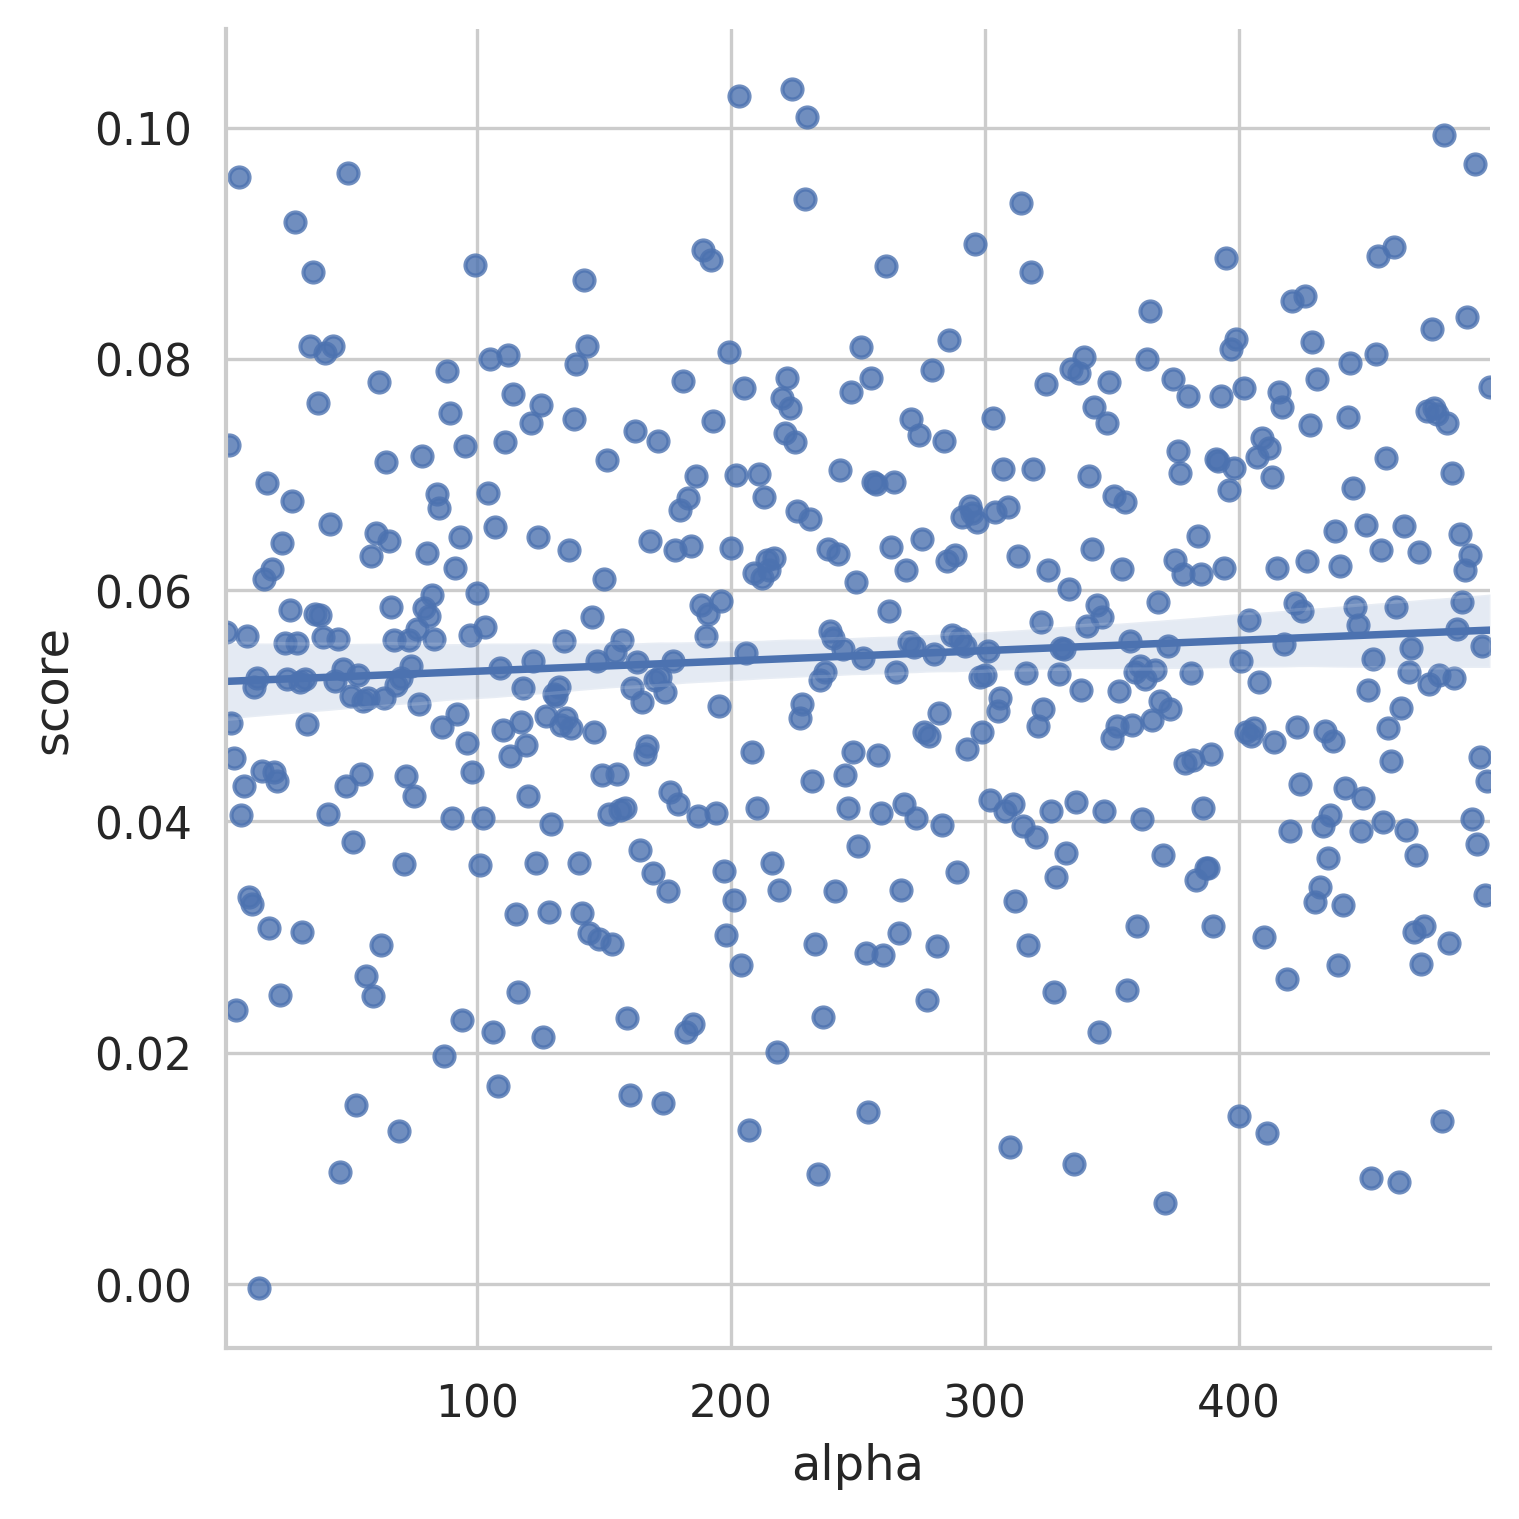

In [23]:
df = pd.DataFrame({'alpha': alphas, 'score': scores})
# display(df)
sns.lineplot(data=df, x='alpha', y='score')
sns.lmplot(data=df, x='alpha', y='score')

In [8]:
%%time
# X_cv = bin_1[0]
# y_cv = bin_1[1]
X_cv = X
y_cv = y
bin_label = 'all'

estimators = [StandardScaler(), MultiOutputRegressor(
    RidgeCV(alphas=[a for a in range(5000, 55000, 5000)], scoring=regression_scorer, cv=rkf))]
pipe = make_pipeline(*estimators)
pipe.fit(X_cv, y_cv)
ridge_cvs = pipe['multioutputregressor'].estimators_

for target, ridge_cv in zip(WISC_LEVEL[5], ridge_cvs):
    print(f'Target: {target} | Alpha: {ridge_cv.alpha_} | Score: {ridge_cv.best_score_:.2f}')

ValueError: y must have at least two dimensions for multi-output regression but has only one.

### Run cross-validation

In [34]:
%%time
# estimators = [StandardScaler(), Ridge(alpha=ridge_cv.alpha_)]
estimators = [StandardScaler(), Ridge(alpha=5000)]
pipe = make_pipeline(*estimators)

scores = cross_validate(pipe, X_cv, y_cv, cv=RKF_10_10, scoring=multimetric_scorer, n_jobs=-1, 
                        return_train_score=True, return_estimator=True)

coefs = np.array([estimator['ridge'].coef_ for estimator in scores['estimator']])
avg_coef = np.mean(coefs, axis=0)
intercepts = np.array([estimator['ridge'].intercept_ for estimator in scores['estimator']])
avg_inte = np.mean(intercepts, axis=0)

print(f'ridge_{population}_{selected_target}_{age_group}')
for metric in SCORING:
    metric_values = scores[metric]
    print(f'Avg {metric}: {np.mean(metric_values):.3f}')

ridge_adhd_WISC_FSIQ_all
Avg train_r: 1.000
Avg test_r: 0.070
Avg test_p_value: 0.490
Avg test_mse: 298.960
CPU times: user 606 ms, sys: 349 ms, total: 955 ms
Wall time: 3.77 s


In [38]:
from os.path import join
from common.paths import RIDGE_WEIGHTS

coef_fn = f'ridge_{population}_{selected_target}_{age_group}_coef.npy'
inte_fn = f'ridge_{population}_{selected_target}_{age_group}_inte.npy'

np.save(join(RIDGE_WEIGHTS, coef_fn), avg_coef)
np.save(join(RIDGE_WEIGHTS, inte_fn), avg_inte)

### ICC

In [34]:
%%time
import pingouin as pg

icc_data = pd.DataFrame(coefs).melt(var_name='connection', value_name='weight', ignore_index=False)
icc_data['cv_run_num'] = icc_data.index
icc = pg.intraclass_corr(data=icc_data, targets='connection', raters='cv_run_num', ratings='weight').round(3)
icc.set_index("Type")

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.897,873.76,34715,3436884,0.0,"[0.9, 0.9]"
ICC2,Single random raters,0.897,873.88,34715,3436785,0.0,"[0.9, 0.9]"
ICC3,Single fixed raters,0.897,873.88,34715,3436785,0.0,"[0.9, 0.9]"
ICC1k,Average raters absolute,0.999,873.76,34715,3436884,0.0,"[1.0, 1.0]"
ICC2k,Average random raters,0.999,873.88,34715,3436785,0.0,"[1.0, 1.0]"
ICC3k,Average fixed raters,0.999,873.88,34715,3436785,0.0,"[1.0, 1.0]"


### Run permutation test statistic (pts)

In [7]:
%%time
score, _, pvalue = permutation_test_score(
    pipe, X_cv, y_cv, cv=RKF_10_10, scoring=unimetric_scorer, n_permutations=N_PERM, n_jobs=-1)

print(f'ridge_{population}_{selected_target}_{age_group}')
print(f'Alpha: {ridge_cv.alpha_} | Score: {score:.2f} | p-value: {pvalue:.4f}')

ridge_healthy_WISC_VCI_all
Alpha: 15000 | Score: 0.23 | p-value: 0.0319
CPU times: user 51.8 s, sys: 1.27 s, total: 53.1 s
Wall time: 11min 4s


## Run for all targets, all age bins

### Run cross-validation

In [53]:
%%time
from os.path import join
from common.binning import bin_data
from common.wisc import FSIQ, PRIMARY_INDICES
from common.paths import RIDGE_WEIGHTS, RIDGE_RESULTS

results = []
targets = FSIQ + PRIMARY_INDICES

for target in targets:
    y = Y[target]
    X_all, y_all, bin_labels = bin_data(X, y)
    
    for X_cv, y_cv, bin_label in zip(X_all, y_all, bin_labels):
        # Find best alpha
        estimators = [StandardScaler(), RidgeCV(alphas=[a for a in range(5000, 75000, 5000)], 
                                        scoring=unimetric_scorer, cv=RKF_10_10)]
        pipe = make_pipeline(*estimators).fit(X_cv, y_cv)
        ridge_cv = pipe['ridgecv']
        
        # Do cross-validation
        estimators = [StandardScaler(), Ridge(alpha=ridge_cv.alpha_)]
        pipe = make_pipeline(*estimators)
        
        scores = cross_validate(pipe, X_cv, y_cv, cv=RKF_10_10, 
                                scoring=unimetric_scorer, n_jobs=-1, 
                                return_train_score=False, 
                                return_estimator=True)
        coefs = np.array([estimator['ridge'].coef_ for estimator in scores['estimator']])
        avg_coef = np.mean(coefs, axis=0)
        intercepts = np.array([estimator['ridge'].intercept_ for estimator in scores['estimator']])
        avg_inte = np.mean(intercepts, axis=0)
        
        results.append({    
            'Model': 'ridge',
            'Population': population,
            'Target': target,
            'Bin': bin_label,
            'Alpha': ridge_cv.alpha_,
            'Score': np.mean(scores['test_score']),
        })
        print(results[-1])
        
        coef_fn = f'ridge_{population}_{target}_{bin_label}_coef.npy'
        inte_fn = f'ridge_{population}_{target}_{bin_label}_inte.npy'
        np.save(join(RIDGE_WEIGHTS, coef_fn), avg_coef)
        np.save(join(RIDGE_WEIGHTS, inte_fn), avg_inte)

results_df = pd.DataFrame(results)
display(results_df.round(4))
filename = f'ridge_cv_{population}.csv'
results_df.to_csv(join(RIDGE_RESULTS, filename))

KeyboardInterrupt: 

### Run permutation test statistic (pts)

In [ ]:
%%time
from os.path import join
from common.binning import bin_data
from common.wisc import FSIQ, PRIMARY_INDICES
from common.paths import RIDGE_RESULTS

results = []
targets = FSIQ + PRIMARY_INDICES

for target in targets:
    y = Y[target]
    X_all, y_all, bin_labels = bin_data(X, y, ages)
    
    for X_cv, y_cv, bin_label in zip(X_all, y_all, bin_labels):
        # Find best alpha
        estimators = [StandardScaler(), RidgeCV(alphas=[a for a in range(1, 10000, 100)], 
                                        scoring=unimetric_scorer, cv=RKF_10_10)]
        pipe = make_pipeline(*estimators).fit(X_cv, y_cv)
        ridge_cv = pipe['ridgecv']
        
        # Do permutation test
        estimators = [StandardScaler(), Ridge(alpha=ridge_cv.alpha_)]
        pipe = make_pipeline(*estimators)
        
        score, permutation_scores, pvalue = permutation_test_score(
            pipe, X_cv, y_cv, cv=RKF_10_10, scoring=unimetric_scorer, n_permutations=N_PERM, 
            n_jobs=-1)
        results.append({    
            'Model': 'ridge',
            'Population': population,
            'Target': target,
            'Bin': bin_label,
            'Alpha': ridge_cv.alpha_,
            'Score': score,
            'P-value': pvalue,
        })
        print(results[-1])
        
results_df = pd.DataFrame(results)
display(results_df.round(4))
# filename = f'ridge_pts_{population}.csv'
# results_df.to_csv(join(RIDGE_RESULTS, filename))

{'Model': 'ridge', 'Population': 'healthy', 'Target': 'WISC_FSIQ', 'Bin': 'All', 'Alpha': 1, 'Score': 0.07673316863962565, 'P-value': 0.29141716566866266}
{'Model': 'ridge', 'Population': 'healthy', 'Target': 'WISC_FSIQ', 'Bin': 'Bin 1', 'Alpha': 1, 'Score': -0.06683356988442851, 'P-value': 0.6287425149700598}
{'Model': 'ridge', 'Population': 'healthy', 'Target': 'WISC_FSIQ', 'Bin': 'Bin 2', 'Alpha': 1, 'Score': -0.14641523611935228, 'P-value': 0.688622754491018}
{'Model': 'ridge', 'Population': 'healthy', 'Target': 'WISC_FSIQ', 'Bin': 'Bin 3', 'Alpha': 9901, 'Score': 0.1277605208673186, 'P-value': 0.1656686626746507}
{'Model': 'ridge', 'Population': 'healthy', 'Target': 'WISC_VSI', 'Bin': 'All', 'Alpha': 1, 'Score': 0.1258296732842334, 'P-value': 0.16966067864271456}
{'Model': 'ridge', 'Population': 'healthy', 'Target': 'WISC_VSI', 'Bin': 'Bin 1', 'Alpha': 1, 'Score': 0.031677225486282205, 'P-value': 0.4351297405189621}
{'Model': 'ridge', 'Population': 'healthy', 'Target': 'WISC_VSI',

/home/bpho/.conda/envs/venv/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/bpho/.conda/envs/venv/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/bpho/.conda/envs/venv/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/bpho/.conda/envs/venv/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/bpho/.conda/envs/venv/lib/python3.7/site-packages/scipy/stats/stat

{'Model': 'ridge', 'Population': 'healthy', 'Target': 'WISC_VSI', 'Bin': 'Bin 3', 'Alpha': 1, 'Score': nan, 'P-value': 0.001996007984031936}


### Run Bootstrapping

In [29]:
%%time
from os.path import join
from common.binning import bin_data
from common.wisc import WISC_LEVEL
from common.paths import RIDGE_WEIGHTS, RIDGE_RESULTS
from common.scoring import bootstrap_permutation_test_score

results = []
targets = WISC_LEVEL[5]
target_alphas = [5000, 5000, 10000, 5000, 20000, 5000]

for target, target_alpha in zip(targets, target_alphas):
    y = Y[target]
    X_all, y_all, bin_labels = bin_data(X, y)
    
    for X_cv, y_cv, bin_label in zip(X_all, y_all, bin_labels):      
        estimators = [StandardScaler(), Ridge(alpha=target_alpha)]
        pipe = make_pipeline(*estimators)
        
        score, permutation_scores, pvalue = bootstrap_permutation_test_score(
            pipe, X_cv, y_cv, cv=RKF_10_10, scoring=unimetric_scorer, n_permutations=N_PERM, 
            n_jobs=-1, bootstrap_n=380)
        
        results.append({    
            'Model': 'ridge',
            'Population': population,
            'Target': target,
            'Bin': bin_label,
            'Alpha': target_alpha,
            'Score': score,
            'P-value': pvalue,
        })
        print(results[-1])

results_df = pd.DataFrame(results)
display(results_df.round(4))
# filename = f'ridge_cv_{population}.csv'
# results_df.to_csv(join(RIDGE_RESULTS, filename))

{'Model': 'ridge', 'Population': 'healthy', 'Target': 'WISC_FSIQ', 'Bin': 'All', 'Alpha': 5000, 'Score': 0.0827405370130169, 'P-value': 0.2435129740518962}
{'Model': 'ridge', 'Population': 'healthy', 'Target': 'WISC_VSI', 'Bin': 'All', 'Alpha': 5000, 'Score': 0.11323778726444304, 'P-value': 0.20758483033932135}
{'Model': 'ridge', 'Population': 'healthy', 'Target': 'WISC_VCI', 'Bin': 'All', 'Alpha': 10000, 'Score': 0.2197000561637914, 'P-value': 0.0499001996007984}
{'Model': 'ridge', 'Population': 'healthy', 'Target': 'WISC_FRI', 'Bin': 'All', 'Alpha': 5000, 'Score': -0.08964237244946599, 'P-value': 0.7365269461077845}
{'Model': 'ridge', 'Population': 'healthy', 'Target': 'WISC_WMI', 'Bin': 'All', 'Alpha': 20000, 'Score': 0.10132584613213673, 'P-value': 0.23952095808383234}
{'Model': 'ridge', 'Population': 'healthy', 'Target': 'WISC_PSI', 'Bin': 'All', 'Alpha': 5000, 'Score': -0.021403878616610892, 'P-value': 0.5788423153692615}


,Model,Population,Target,Bin,Alpha,Score,P-value
0,ridge,healthy,WISC_FSIQ,All,5000,0.0827,0.2435
1,ridge,healthy,WISC_VSI,All,5000,0.1132,0.2076
2,ridge,healthy,WISC_VCI,All,10000,0.2197,0.0499
3,ridge,healthy,WISC_FRI,All,5000,-0.0896,0.7365
4,ridge,healthy,WISC_WMI,All,20000,0.1013,0.2395
5,ridge,healthy,WISC_PSI,All,5000,-0.0214,0.5788


CPU times: user 22min 2s, sys: 35.8 s, total: 22min 38s
Wall time: 5h 56min 39s
